In [2]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [1]:
from lib import evaluate
from lib.serialize import iter_jl
import pandas as pd


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
dict_genres = {'pop': 1, 'country': 2, 'blues': 3, 'rock': 4, 'jazz': 5, "reggae": 6, "hip hop": 7}

In [4]:
df = pd.read_csv('tcc_ceds_music.csv')

In [5]:
df['genre'] = df['genre'].apply(lambda x: dict_genres[x])

In [6]:
df.head()

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
0,0,mukesh,mohabbat bhi jhoothi,1950,1,hold time feel break feel untrue convince spea...,95,0.000598,0.063746,0.000598,...,0.380299,0.117175,0.357739,0.454119,0.997992,0.901822,0.339448,0.137110,sadness,1.0
1,4,frankie laine,i believe,1950,1,believe drop rain fall grow believe darkest ni...,51,0.035537,0.096777,0.443435,...,0.001284,0.001284,0.331745,0.647540,0.954819,0.000002,0.325021,0.263240,world/life,1.0
2,6,johnnie ray,cry,1950,1,sweetheart send letter goodbye secret feel bet...,24,0.002770,0.002770,0.002770,...,0.002770,0.225422,0.456298,0.585288,0.840361,0.000000,0.351814,0.139112,music,1.0
3,10,pérez prado,patricia,1950,1,kiss lips want stroll charm mambo chacha merin...,54,0.048249,0.001548,0.001548,...,0.225889,0.001548,0.686992,0.744404,0.083935,0.199393,0.775350,0.743736,romantic,1.0
4,12,giorgos papadopoulos,apopse eida oneiro,1950,1,till darling till matter know till dream live ...,48,0.001350,0.001350,0.417772,...,0.068800,0.001350,0.291671,0.646489,0.975904,0.000246,0.597073,0.394375,romantic,1.0


In [7]:
train, test = evaluate.date_split(df)

In [8]:
X_train, y_train = evaluate.x_y_split(train)
X_test, y_test = evaluate.x_y_split(test)

In [9]:
evaluate.to_json_lines(X_train,y_train,'train')
evaluate.to_json_lines(X_test,y_test,'test')

In [10]:
X_train, y_train = iter_jl('X_train.jl'), iter_jl('y_train.jl')

In [11]:
X_test, y_test = iter_jl('X_test.jl'), iter_jl('y_test.jl')

In [12]:
X_train = list(X_train)
y_train = list(y_train)
X_test = list(X_test)
y_test = list(y_test)

In [43]:
from lib.transformers import FeatureProjectionFromJson, TargetEncoder, PretrainedFastTextTransformer, TargetEncodeWithNumerical
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

fields = ['age','violence','world/life','night/time', 'shake the audience',
                            'family/gospel','romantic','communication','obscene','music','movement/places',
                           'light/visual perceptions','family/spiritual','sadness',
                           'danceability','loudness','acousticness','instrumentalness','valence','energy'] 
#saque algunos numericos: 'dating','like/girls','feelings',

features_pipe = make_union(make_pipeline(
        FeatureProjectionFromJson(fields)
    ,SimpleImputer()
),
                          make_pipeline(TargetEncodeWithNumerical('topic', fields)),
                           make_pipeline(TargetEncodeWithNumerical('artist_name', fields)),
                           make_pipeline(PretrainedFastTextTransformer('lyrics_fasttext.bin','lyrics'))
                          )

In [44]:
import lightgbm as lgb

In [45]:
rf_pipe = make_pipeline(
    features_pipe,
    lgb.LGBMClassifier(n_estimators =  100, random_state=42, class_weight = 'balanced')
)
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('featureprojectionfromjson',
                                                                  FeatureProjectionFromJson(fields=['age',
                                                                                                    'violence',
                                                                                                    'world/life',
                                                                                                    'night/time',
                                                                                                    'shake '
                                                                                                    'the '
                                                                                                    'audience',
                                  

In [46]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def get_metrics_multi(y_true, y_pred):
    dicc = {'f1': f1_score(y_true, y_pred, average = 'macro'),
      'precision': precision_score(y_true, y_pred, average = 'macro'),
      'acc': accuracy_score(y_true, y_pred),
      'recall': recall_score(y_true, y_pred, average = 'macro')}
    print(dicc)
    return(dicc)

In [47]:
get_metrics_multi(y_train,rf_pipe.predict(X_train))

{'f1': 0.9738126309181293, 'precision': 0.9714448624656292, 'acc': 0.9671052631578947, 'recall': 0.9763740669587105}


{'f1': 0.9738126309181293,
 'precision': 0.9714448624656292,
 'acc': 0.9671052631578947,
 'recall': 0.9763740669587105}

In [48]:
preds = rf_pipe.predict(X_test)

In [49]:
get_metrics_multi(y_test,preds)

{'f1': 0.6883958407994448, 'precision': 0.7066477173800066, 'acc': 0.6861344537815126, 'recall': 0.6841020109121635}


{'f1': 0.6883958407994448,
 'precision': 0.7066477173800066,
 'acc': 0.6861344537815126,
 'recall': 0.6841020109121635}

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pylab as plt

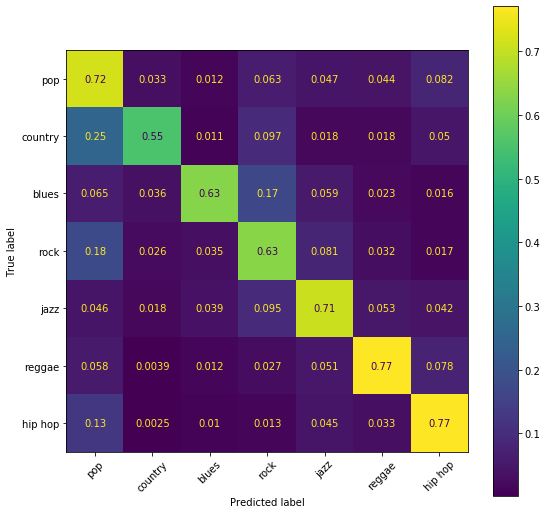

In [51]:
fig, ax  = plt.subplots(figsize=(9, 9))
disp = ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize='true', ax=ax)
ax.xaxis.set_ticklabels(list(dict_genres.keys()))
ax.yaxis.set_ticklabels(list(dict_genres.keys()))
ax.xaxis.set_tick_params(rotation=45)

In [24]:
def get_confused_with(trueCategory,predictedCategory):
    indexes = []
    for i,(pred,true) in enumerate(zip(preds,y_test)):
        if pred == predictedCategory and true == trueCategory:
            indexes.append(i)
    return indexes

In [26]:
test.iloc[get_confused_with(2,1)]

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
12211,38224,charles kelley,lonely girl,2016,2,matter cry wasn dream gotta tell wasn good lon...,64,0.000849,0.000849,0.000849,...,0.372014,0.022126,0.779053,0.757916,0.073292,0.000000,0.739283,0.663653,sadness,0.057143
12226,38313,brothers osborne,pawn shop,2016,2,bill need cash like yesterday junk lay credit ...,105,0.001196,0.001196,0.170479,...,0.001196,0.001196,0.626340,0.759762,0.082529,0.000022,0.975268,0.885882,obscene,0.057143
12241,38387,jelly roll,when i get rich,2016,2,yeah yeah yeah tell yeah mammy break yesterday...,181,0.030875,0.025906,0.000399,...,0.363573,0.000399,0.458464,0.760480,0.081626,0.000000,0.548640,0.905903,sadness,0.057143
12244,38395,chase bryant,room to breathe,2016,2,girl heart beat chest baby leave bring close l...,18,0.117100,0.003509,0.003509,...,0.548289,0.003509,0.709737,0.791067,0.040059,0.000002,0.799052,0.761754,sadness,0.057143
12246,38401,justin moore,got it good,2016,2,wake morning warn little bounce blue eye start...,124,0.017975,0.000474,0.000474,...,0.000474,0.414480,0.743312,0.768761,0.223895,0.000167,0.611500,0.622611,feelings,0.057143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12468,39623,adam calhoun,clean money,2019,2,sure doin puttin hard work earn early wanna cl...,168,0.000358,0.000358,0.000358,...,0.000358,0.000358,0.542944,0.732021,0.055923,0.000000,0.286892,0.502487,obscene,0.014286
12478,39672,kane brown,live forever,2019,2,life breathin like movie sound turn felt nothi...,77,0.000741,0.000741,0.334113,...,0.000741,0.000741,0.701072,0.704330,0.689759,0.000000,0.333265,0.392373,world/life,0.014286
12479,39674,riley green,in love by now,2019,2,windows roll petty singin tan summer dancin lo...,84,0.000774,0.000774,0.000774,...,0.058974,0.098387,0.560273,0.793349,0.002268,0.000000,0.732069,0.886883,obscene,0.014286
12483,39717,john gurney,drink i think,2019,2,feel come alive take black break skin shake fo...,71,0.000849,0.449796,0.000849,...,0.260982,0.000849,0.617676,0.755173,0.362449,0.000005,0.614592,0.725717,violence,0.014286


In [60]:
unseen_artists_test = test[~test['artist_name'].isin(train['artist_name'].unique())]

In [69]:
X_unseen_artists_test, y_unseen_artists_test = evaluate.x_y_split(unseen_artists_test)
evaluate.to_json_lines(X_unseen_artists_test,y_unseen_artists_test,'unseen_artists_test')
X_unseen_artists_test, y_unseen_artists_test = list(iter_jl('X_unseen_artists_test.jl')), list(iter_jl('y_unseen_artists_test.jl'))

In [71]:
unseen_artists_preds = rf_pipe.predict(X_unseen_artists_test)

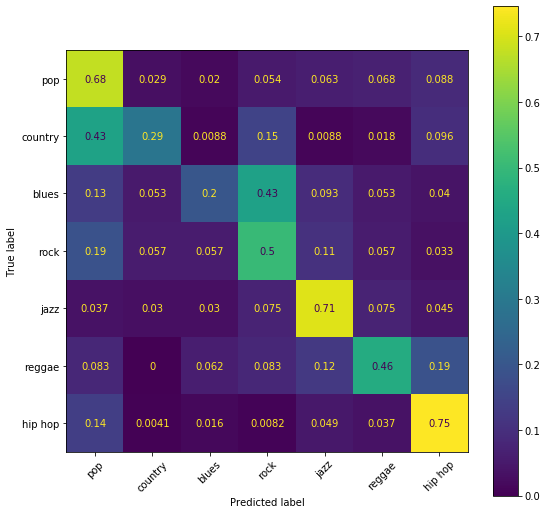

In [72]:
fig, ax  = plt.subplots(figsize=(9, 9))
disp = ConfusionMatrixDisplay.from_predictions(y_unseen_artists_test, unseen_artists_preds, normalize='true', ax=ax)
ax.xaxis.set_ticklabels(list(dict_genres.keys()))
ax.yaxis.set_ticklabels(list(dict_genres.keys()))
ax.xaxis.set_tick_params(rotation=45)

In [73]:
get_metrics_multi(y_unseen_artists_test,unseen_artists_preds)

{'f1': 0.5060621774794892, 'precision': 0.5316330215619497, 'acc': 0.5811240721102863, 'recall': 0.5121111002724187}


{'f1': 0.5060621774794892,
 'precision': 0.5316330215619497,
 'acc': 0.5811240721102863,
 'recall': 0.5121111002724187}